# RemovalCM

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

from htc.context.manipulated_datasets.utils import compare_performance
from htc.context.settings_context import settings_context
from htc.fonts.set_font import set_font
from htc.settings_seg import settings_seg
from htc.utils.helper_functions import sort_labels_cm

set_font(16)

In [2]:
# Load cm
experiment_name = "organ_removal_0"
experiment_dir = (
    settings_context.results_dir
    / "neighbour_analysis"
    / experiment_name
    / "image/2022-02-03_22-58-44_generated_default_model_comparison"
)
confusion_matrix, column_names = compare_performance(experiment_name=experiment_name, experiment_dir=experiment_dir)

labels = [l for l in settings_seg.label_colors_paper.keys() if l in column_names]
confusion_matrix = sort_labels_cm(confusion_matrix, cm_order=column_names, target_order=labels)

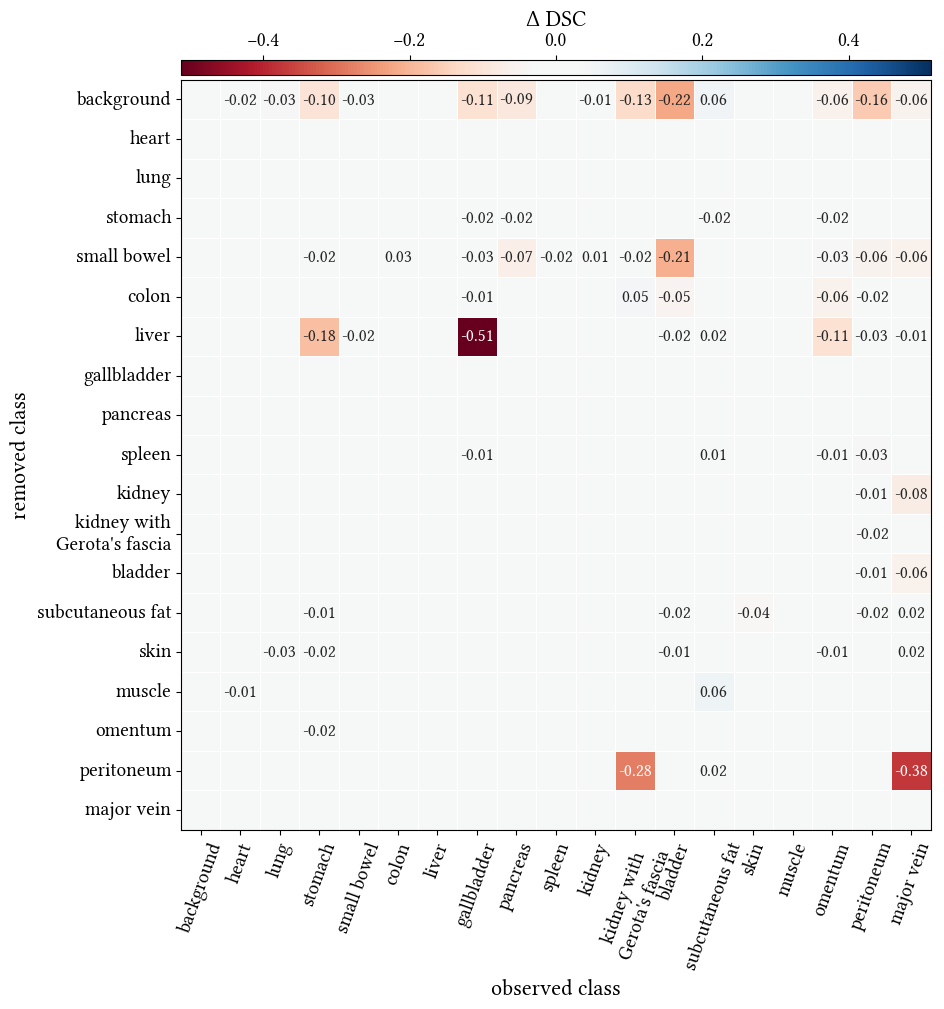

In [3]:
# Colorbar with greater diverging middle: https://stackoverflow.com/a/59273964
max_value = max(confusion_matrix.min().abs().item(), confusion_matrix.min().abs().item())
f = lambda x: np.interp(x, p, [0, 0.5, 0.5, 1])
p = [-max_value, -0.04, 0.04, max_value]
cmap = LinearSegmentedColormap.from_list(
    "map_white",
    list(zip(np.linspace(0, 1), plt.cm.RdBu(f(np.linspace(min(p), max(p)))))),
)

# Hide small numbers
text = np.vectorize(lambda x: "" if abs(x) < 0.01 else f"{x:.2f}")(confusion_matrix)

labels_paper_renaming = {
    "major_vein": "major vein",
    "small_bowel": "small bowel",
    "kidney_with_Gerotas_fascia": "kidney with\nGerota's fascia",
    "fat_subcutaneous": "subcutaneous fat",
}
label_names = [labels_paper_renaming.get(l, l) for l in labels]

# Colorbar with greater diverging middle: https://stackoverflow.com/a/59273964
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(
    confusion_matrix,
    annot=text,
    linewidths=0.5,
    cmap=cmap,
    cbar=False,
    vmin=min(p),
    vmax=max(p),
    ax=ax,
    annot_kws={"size": 12.5},
    fmt="s",
    xticklabels=label_names,
    yticklabels=label_names,
)
for t in ax.xaxis.get_ticklabels():
    t.set_rotation(70)

ax.set_xlabel("observed class")
ax.set_ylabel("removed class", loc="center")

# Black box
for _, spine in ax.spines.items():
    spine.set_visible(True)

# Customize colorbar
size = "2%"
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size=size, pad=0.05)
im = ax.imshow(confusion_matrix, cmap=cmap, vmin=min(p), vmax=max(p))
cbar = plt.colorbar(im, cax=cax, cmap=cmap, shrink=0.6, orientation="horizontal")
cbar.ax.xaxis.set_ticks_position("top")
cbar.ax.xaxis.set_label_position("top")
cbar.set_label("Δ DSC")

plt.savefig(settings_context.paper_dir / "cm_removal_0.pdf", bbox_inches="tight");